In [11]:
# inclusions
import numpy as np
import matplotlib.pyplot as plt
import random
from numba import jit, njit, types, vectorize

In [12]:
@jit(nopython=True)
def monte_carlo_pi(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x ** 2 + y ** 2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

def monte_carlo_pi_no_numba(nsamples):
    acc = 0
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x ** 2 + y ** 2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

In [13]:
%time monte_carlo_pi_no_numba(10000)

CPU times: total: 0 ns
Wall time: 3.99 ms


3.1576

In [18]:
%time monte_carlo_pi(10000)
%time monte_carlo_pi(10000)

CPU times: total: 0 ns
Wall time: 0 ns
CPU times: total: 0 ns
Wall time: 0 ns


3.136

In [20]:
def original_function(input_list):
    output_list = []
    for item in input_list:
        if item % 2 == 0:
            output_list.append(2)
        else:
            output_list.append('1')
    return output_list

test_list = list(range(100000))

In [21]:
original_function(test_list)[0:10]

[2, '1', 2, '1', 2, '1', 2, '1', 2, '1']

In [22]:
jitted_function = jit()(original_function)

In [24]:
%time _ = original_function(test_list)

CPU times: total: 15.6 ms
Wall time: 8.97 ms


In [26]:
%time _ = jitted_function(test_list)

CPU times: total: 15.6 ms
Wall time: 24.9 ms


In [33]:
@vectorize(nopython=True)
def non_list_function(item):
    if item % 2 == 0:
        return 2
    else:
        return 1

In [35]:
%time non_list_function(test_list)

CPU times: total: 0 ns
Wall time: 0 ns


array([2, 1, 2, ..., 1, 2, 1], dtype=int64)

In [36]:
@njit
def allocated_func(input_list):
    output_list = np.zeros_like(input_list)
    for ii, item in enumerate(input_list):
        if item % 2 == 0:
            output_list[ii] = 2
        else:
            output_list[ii] = 1
    return output_list

In [37]:
%time allocated_func(test_list)

CPU times: total: 109 ms
Wall time: 109 ms


array([2, 1, 2, ..., 1, 2, 1])

In [56]:
%time allocated_func(test_list)

CPU times: total: 0 ns
Wall time: 0 ns


array([2, 1, 2, ..., 1, 2, 1])

In [57]:
%time non_list_function(test_list)

CPU times: total: 0 ns
Wall time: 0 ns


array([2, 1, 2, ..., 1, 2, 1], dtype=int64)

## Now do the simulation part of the tutorial 

In [58]:
# Let's mix wet friction with dry friction, this makes the behavior
# of the system dependent on the initial condition, something
# may be interesting to study by running an exhaustive simluation

def friction_fn(v, vt):
    if v > vt:
        return - v * 3
    else:
        return - vt * 3 * np.sign(v)

def simulate_spring_mass_funky_damper(x0, T=10, dt=0.0001, vt=1.0):
    times = np.arange(0, T, dt)
    positions = np.zeros_like(times)
    
    v = 0
    a = 0
    x = x0
    positions[0] = x0/x0
    
    for ii in range(len(times)):
        if ii == 0:
            continue
        t = times[ii]
        a = friction_fn(v, vt) - 100*x
        v = v + a*dt
        x = x + v*dt
        positions[ii] = x/x0
    return times, positions

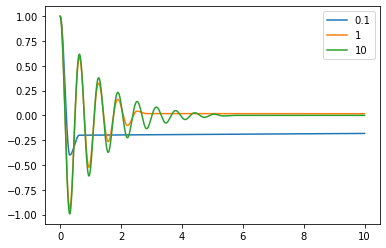

In [59]:
plt.plot(*simulate_spring_mass_funky_damper(0.1))
plt.plot(*simulate_spring_mass_funky_damper(1))
plt.plot(*simulate_spring_mass_funky_damper(10))
plt.legend(['0.1', '1', '10'])

In [60]:
%time _ = simulate_spring_mass_funky_damper(0.1)

CPU times: total: 188 ms
Wall time: 178 ms


In [70]:
@njit
def friction_fn(v, vt):
    if v > vt:
        return - v * 3
    else:
        return - vt * 3 * np.sign(v)

@njit
def simulate_spring_mass_funky_damper(x0, T=10, dt=0.0001, vt=1.0):
    times = np.arange(0, T, dt)
    positions = np.zeros_like(times)
    
    v = 0
    a = 0
    x = x0
    positions[0] = x0/x0
    
    for ii in range(len(times)):
        if ii == 0:
            continue
        t = times[ii]
        a = friction_fn(v, vt) - 100*x
        v = v + a*dt
        x = x + v*dt
        positions[ii] = x/x0
    return times, positions

_ = simulate_spring_mass_funky_damper(0.1)

In [71]:
%time _ = simulate_spring_mass_funky_damper(0.1)

CPU times: total: 31.2 ms
Wall time: 1.21 ms


In [72]:
%%time
from concurrent.futures import ThreadPoolExecutor

with ThreadPoolExecutor(8) as ex:
    ex.map(simulate_spring_mass_funky_damper, np.arange(0, 1000, 0.1))

CPU times: total: 9.84 s
Wall time: 9.85 s


In [73]:
@njit(nogil=True)
def friction_fn(v, vt):
    if v > vt:
        return - v * 3
    else:
        return - vt * 3 * np.sign(v)

@njit(nogil=True)
def simulate_spring_mass_funky_damper(x0, T=10, dt=0.0001, vt=1.0):
    times = np.arange(0, T, dt)
    positions = np.zeros_like(times)
    
    v = 0
    a = 0
    x = x0
    positions[0] = x0/x0
    
    for ii in range(len(times)):
        if ii == 0:
            continue
        t = times[ii]
        a = friction_fn(v, vt) - 100*x
        v = v + a*dt
        x = x + v*dt
        positions[ii] = x/x0
    return times, positions

# compile
_ = simulate_spring_mass_funky_damper(0.1)

In [76]:
%%time
from concurrent.futures import ThreadPoolExecutor

with ThreadPoolExecutor(20) as ex:
    ex.map(simulate_spring_mass_funky_damper, np.arange(0, 1000, 0.1))

CPU times: total: 6.88 s
Wall time: 918 ms


In [77]:
from numba import prange
@njit(nogil=True, parallel=True)
def run_sims(end=1000):
    for x0 in prange(int(end/0.1)):
        if x0 == 0:
            continue
        simulate_spring_mass_funky_damper(x0*0.1)
        
run_sims()

In [78]:
%time run_sims()

CPU times: total: 6.44 s
Wall time: 493 ms
